In [1]:
import os
from google.colab import drive
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/DP")

Mounted at /content/drive


In [2]:
from __future__ import print_function
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import itertools
import sys
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sklearn
from datetime import datetime
import time
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

sys.path.append("../")

* features:
['ED[vol(LV)]', 'ES[vol(LV)]', 'ED[vol(RV)]', 'ES[vol(RV)]', 'ED[mass(MYO)]', 'ES[vol(MYO)]', 'EF(LV)', 'EF(RV)', 'ED[vol(LV)/vol(RV)]', 'ES[vol(LV)/vol(RV)]', 'ED[mass(MYO)/vol(LV)]', 'ES[vol(MYO)/vol(LV)]', 'ES[max(mean(MWT|SA)|LA)]', 'ES[stdev(mean(MWT|SA)|LA)]', 'ES[mean(stdev(MWT|SA)|LA)]', 'ES[stdev(stdev(MWT|SA)|LA)]', 'ED[max(mean(MWT|SA)|LA)]', 'ED[stdev(mean(MWT|SA)|LA)]', 'ED[mean(stdev(MWT|SA)|LA)]', 'ED[stdev(stdev(MWT|SA)|LA)]']
Generating features learnt from decision trees
Results of training on Decision trees:
Score on Manually segmented Test Set
[0 3 1 0 2 3 3 2 4 4 2 0 1 1 0]
0.8
Results of training on Random Forest:
Score on Manually segmented Test Set
[0 3 1 0 2 3 3 2 4 4 1 0 1 1 0]
0.8666666666666667
Confusion matrix, without normalization
[[3 0 0 0 0]
 [0 3 0 0 0]
 [0 1 2 0 0]
 [0 0 0 3 0]
 [1 0 0 0 2]]
Results of training MLP:
Score on manually segmented Validation Set
[0 3 1 0 1 3 3 2 4 4 1 4 1 2 0]
0.9333333333333333
Confusion matrix, without norma

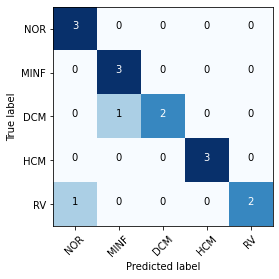

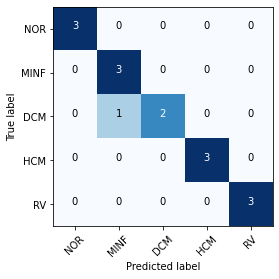

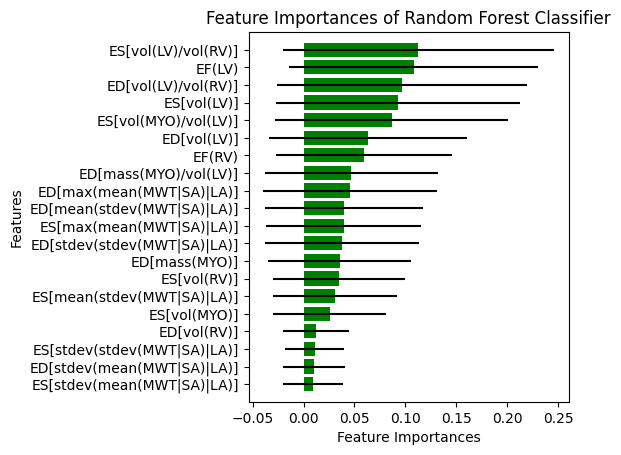

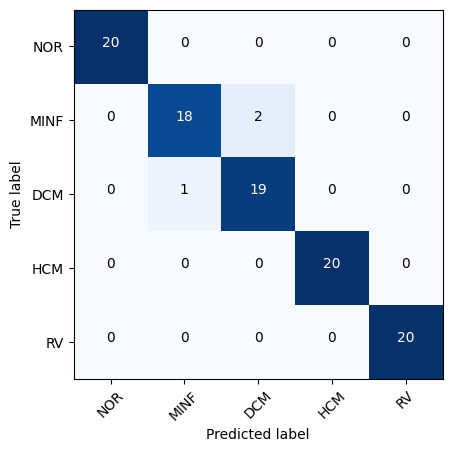

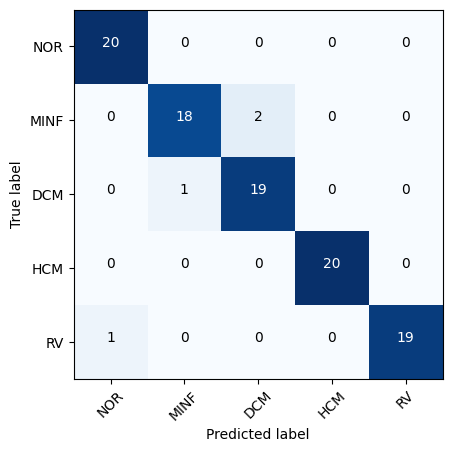

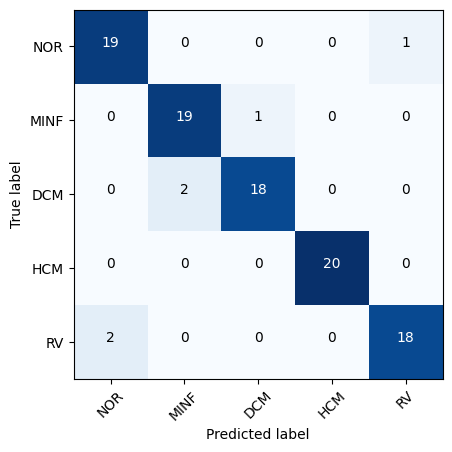

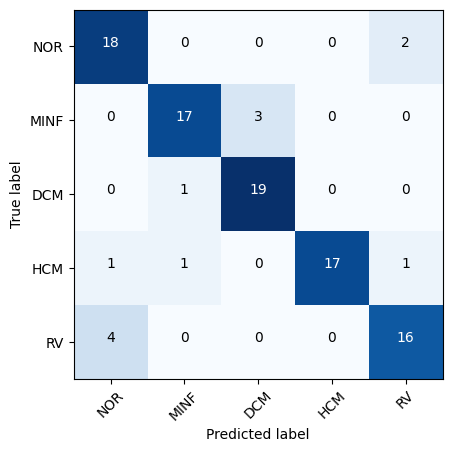

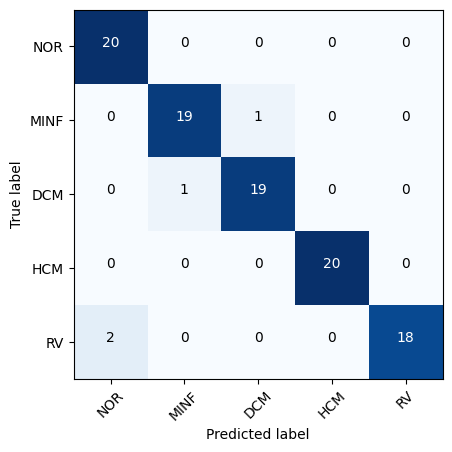

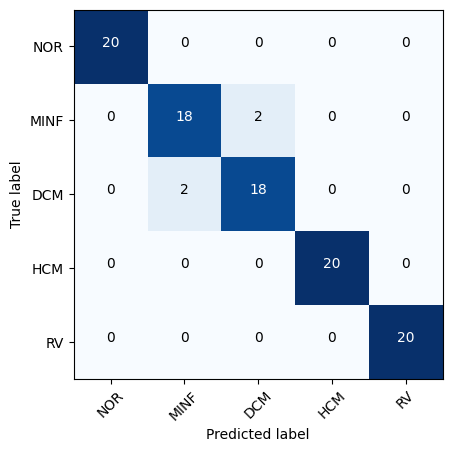

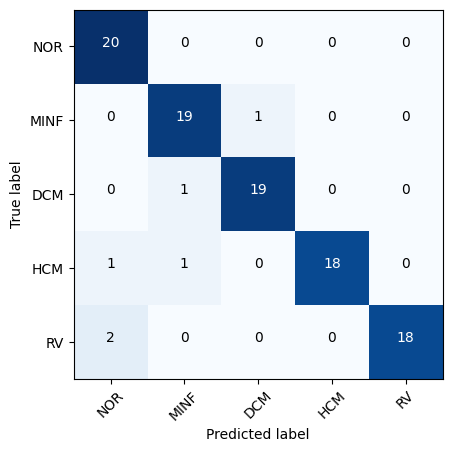

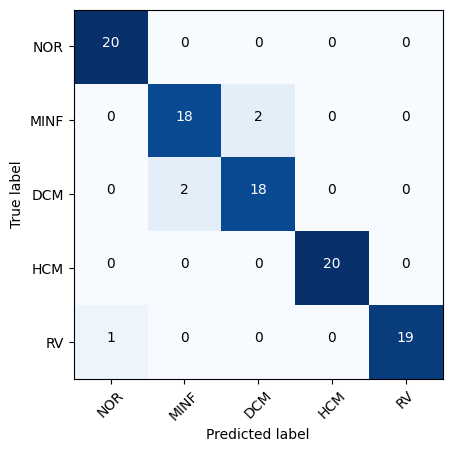

In [3]:
# Disease Mapping
NOR = 'NOR'
MINF = 'MINF'
DCM = 'DCM'
HCM = 'HCM'
RV = 'RV'
heart_disease_label_map = {NOR:0, MINF:1,DCM:2,HCM:3, RV:4}

# Path to cardiac features generated from given manually annotated training data
# These features are used for training and validation of model
full_training = './training_data/Cardiac_parameters_training.csv'

train = './training_data/Cardiac_parameters_train.csv'
validation = './training_data/Cardiac_parameters_validation.csv'

# Features columns selection
START_COL = 1
END_COL = 21

class_names = [NOR, MINF, DCM, HCM, RV]
class_names_for_cm = [NOR, MINF, DCM, HCM, 'RV']

def visualize_tree(tree, feature_names, save_dir='./'):
    """Create tree png using graphviz.
    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open(save_dir+'/'+"dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", save_dir+"/dt.dot", "-o", save_dir+"/dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

def encode_target(df, target_column, label_map):
    """Add column to df with integers for the target.
    Args
    ----
    df -- pandas DataFrame.
    target_column -- column to map to int, producing
                     new Target column.
    Returns
    -------
    df_mod -- modified DataFrame.
    targets -- list of target names.
    """
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    # map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod[target_column] = df_mod[target_column].replace(label_map)

    return (df_mod, targets)

def load_dataframe(csv_file, shuffle=False):
    """
    Load Patient information from the csv file as a dataframe
    """
    df = pd.read_csv(csv_file)
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
    # patient_data = df.to_dict("records")
    # return patient_data
    return df


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Tweak spacing to prevent clipping of tick-labels
    plt.subplots_adjust(bottom=0.2)

def CardiacDiagnosisModelTester(clf, final_test_path, name, scaler, save_dir='./', label_available=False, prediction_csv=None):
    """
    This code does the cardiac disease classification (5-classes)
    """
    class_names = [NOR, MINF, DCM, HCM, RV]
    df = load_dataframe(final_test_path)
    features = list(df.columns[np.r_[START_COL:END_COL]])
    X_df = df[features]
    # print (features)
    X_scaled = scaler.transform(X_df)  
    y_pred = clf.predict(X_scaled)
    print ("Writing predictions to file", name)
    target = open(save_dir+'/'+ name+'predictions_{}.txt'.format(time.strftime("%Y%m%d_%H%M%S")), 'w')
    classes = {NOR: 0,MINF:0,DCM:0,HCM:0,RV:0}
    for pid, pred in zip(df['Name'], y_pred):
        classes[class_names[pred]] +=1
        line = '{} {}'.format(pid, class_names[pred])
        target.write(line)
        target.write("\n")
    target.close()
    print (classes)
    if label_available:
        y_true,_ = encode_target(df, 'GROUP', heart_disease_label_map)
        accuracy = accuracy_score(y_true['GROUP'], y_pred)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))

if __name__ == '__main__':

    save_dir ='./Stage_1_Predictions{}'.format(time.strftime("%Y%m%d_%H%M%S"))
    os.makedirs(save_dir)   
    # Prepare the feature vectors for training and validation
    train_df, train_targets = encode_target(load_dataframe(train), 'GROUP', heart_disease_label_map)
    valid_df, _ = encode_target(load_dataframe(validation), 'GROUP', heart_disease_label_map)
    # Select the features:
    features = list(train_df.columns[np.r_[START_COL:END_COL]])
    print("* features:", features, sep="\n")
    X_train = train_df[features]
    y_train = train_df['GROUP']
    X_valid = valid_df[features]
    y_valid = valid_df['GROUP']

    ################ Model trained on simple decision train #############
    DT_clf = DecisionTreeClassifier(min_samples_split=10, random_state=99)
    DT_clf.fit(X_train, y_train)
    print ('Generating features learnt from decision trees')
    # Code to visualize learnt features
    visualize_tree(DT_clf, features, save_dir=save_dir)
    print ('Results of training on Decision trees:')
    print ('Score on Manually segmented Test Set')
    print (DT_clf.predict(X_valid))
    print (DT_clf.score(X_valid, y_valid))

    
    ################# Model trained on Random Forest ##################
    n_estimators = 1000
    RF_clf = RandomForestClassifier(n_estimators=n_estimators)
    RF_clf.fit(X_train, y_train)
    print ('Results of training on Random Forest:')
    print ('Score on Manually segmented Test Set')
    y_pred = RF_clf.predict(X_valid)
    print (y_pred)
    print (RF_clf.score(X_valid, y_valid))
    # Predict on Manually segmentation results
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_valid, y_pred)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names_for_cm,
                          title='Confusion matrix: Random Forest classifier on Validation Set')
    # plt.show()
    plt.savefig(save_dir+'/confusion_matrix_Manual_RF')

    ################# Model trained on MLP ##################
    print ('Results of training MLP:')
    scaler = StandardScaler() 
    scaler.fit(X_train) 
    X_scaled = scaler.transform(X_train)
    MLP_clf = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=1, max_iter=1000)
    MLP_clf.fit(X_scaled, y_train)

    print ('Score on manually segmented Validation Set')
    y_pred = MLP_clf.predict(scaler.transform(X_valid))
    print (y_pred)
    print (MLP_clf.score(scaler.transform(X_valid), y_valid))

    # Predict on Manually segmentation results
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_valid, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names_for_cm,
                          title='Confusion matrix: MLP classifier on Validation Set')
    # plt.show()
    plt.savefig(save_dir+'/confusion_matrix_Manual_MLP')

    #***************** Feature importances study of the forest *****************#
    # Build a forest and compute the feature importances
    # forest = ExtraTreesClassifier(n_estimators=n_estimators,
    #                               random_state=0)
    forest = RandomForestClassifier(n_estimators=n_estimators,
                                  random_state=0)
    forest.fit(X_train, y_train)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(X_train.shape[1]):
        print("%d. feature: %s \t %d (%f)" % (f + 1, features[indices[f]], indices[f], importances[indices[f]]))

    #***************** Plot the feature importances of the forest *****************#
    indices = np.argsort(importances)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    sorted_features =  [features[i] for i in indices]
    y_pos = np.arange(len(sorted_features))
    ax.barh(y_pos, importances[indices], xerr=std[indices], align='center',
            color='green', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_features)
    # ax.invert_yaxis()  # labels read top-to-bottom
    # Green bars are the feature importances of the forest and black indicate their inter-trees variability (Stddev)
    ax.set_xlabel('Feature Importances')
    ax.set_ylabel('Features')

    ax.set_title('Feature Importances of Random Forest Classifier')
    plt.subplots_adjust(left=0.4)
    plt.ylim([-1, X_train.shape[1]])
    # plt.show()
    plt.savefig(save_dir+'/Important_features')

    #************************* Cross-Validation Study ****************************#
    # Perform Cross_Validation: With Splits of 5
    print ('Doing cross-validation for Ensemble')
    # Cross-validation on full training_set
    train_df, train_targets = encode_target(load_dataframe(full_training, shuffle=False), 'GROUP', heart_disease_label_map)
    # Select the features:
    features = list(train_df.columns[np.r_[START_COL:END_COL]])
    # print("* features:", features, sep="\n")
    X = train_df[features]
    y = train_df['GROUP']
    # Scale the feature vectors using standard scaler
    scaler = StandardScaler() 
    scaler.fit(X) 
    X_scaled = scaler.transform(X)

    # Range of classifiers experimented with
    RF_clf = RandomForestClassifier(n_estimators=n_estimators)
    XG_clf = XGBClassifier(n_estimators=n_estimators)
    MLP_clf = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=1, max_iter=1000)
    LR_clf = LogisticRegression()
    GNB_clf = GaussianNB()
    SVM_clf = svm.SVC(kernel='rbf', probability=True)
    KNN_clf = KNeighborsClassifier(n_neighbors=5)

    # Voting Classifier 
    E_clf = VotingClassifier(estimators=[('mlp', MLP_clf),  ('gnb', GNB_clf), ('svm', SVM_clf), ('rf', RF_clf)], voting='soft')

    for clf, label in zip([LR_clf, RF_clf, GNB_clf, XG_clf, SVM_clf, MLP_clf, KNN_clf, E_clf], ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'XG_boost', 'SVM', 'MLP', 'KNN', 'Ensemble']):
        scores = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy')
        print (scores)
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
        predictions = cross_val_predict(clf, X_scaled, y, cv=5)
        incorrect_idx = [i for i, val in enumerate(predictions != y) if val]
        print (predictions)
        print (train_df['Name'][incorrect_idx])
        print ('Truth', [class_names[x] for x in y[incorrect_idx]])
        print ('Predicted', [class_names[x] for x in predictions[incorrect_idx]])
        cnf_matrix = confusion_matrix(y, predictions)
        np.set_printoptions(precision=2)

        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names_for_cm,
                              title='Confusion matrix: {} classifier'.format(label))
        # plt.show()
        plt.savefig(save_dir+'/confusion_matrix_Manual_{}'.format(label))
    #********************* Evaluate Ensemble classifier model on Validation Set******************************# 
    EN_clf = E_clf.fit(X_scaled, y)
    # TODO: If preferred Naive Bayes over Ensemble 
    # EN_clf = GNB_clf.fit(X_scaled, y)
    # EN_clf = MLP_clf.fit(X_scaled, y)
    # EN_clf = SVM_clf.fit(X_scaled, y)
    # EN_clf = RF_clf.fit(X_scaled, y)
    ##################### Automated Caridiac Diagnosis on Final Test data ########################### 
    # No Group/label is available in final test dataset 
    # CardiacDiagnosisModelTester(EN_clf, test_on_prediction, name='EnsembleOnFinalTestSet', scaler=scaler, save_dir=save_dir, label_available=False,
    #                             prediction_csv=test_on_prediction)

In [ ]:
DT_clf = DecisionTreeClassifier(min_samples_split=10, random_state=99)
DT_clf.fit(X_train, y_train)
print ('Generating features learnt from decision trees')
# Code to visualize learnt features
visualize_tree(DT_clf, features, save_dir=save_dir)
print ('Results of training on Decision trees:')
print ('Score on Manually segmented Test Set')
print (DT_clf.predict(X_valid))
print (DT_clf.score(X_valid, y_valid))

Generating features learnt from decision trees
Results of training on Decision trees:
Score on Manually segmented Test Set
[0 3 1 0 2 3 3 2 4 4 2 0 1 1 0]
0.8


Results of training on Random Forest:
Score on Manually segmented Test Set
[0 3 1 0 2 3 3 2 4 4 1 0 1 1 0]
0.8666666666666667
Confusion matrix, without normalization
[[3 0 0 0 0]
 [0 3 0 0 0]
 [0 1 2 0 0]
 [0 0 0 3 0]
 [1 0 0 0 2]]


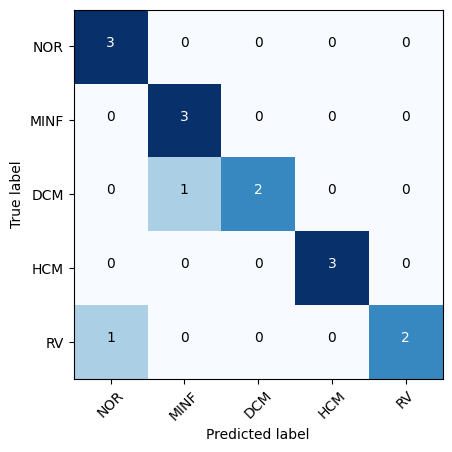

In [4]:
n_estimators = 1000
RF_clf = RandomForestClassifier(n_estimators=n_estimators)
RF_clf.fit(X_train, y_train)
print ('Results of training on Random Forest:')
print ('Score on Manually segmented Test Set')
y_pred = RF_clf.predict(X_valid)
print (y_pred)
print (RF_clf.score(X_valid, y_valid))
# Predict on Manually segmentation results
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_for_cm,
                      title='Confusion matrix: Random Forest classifier on Validation Set')
# plt.show()
plt.savefig(save_dir+'/confusion_matrix_Manual_RF')

Results of training MLP:
Score on manually segmented Validation Set
[0 3 1 0 1 3 3 2 4 4 1 4 1 2 0]
0.9333333333333333
Confusion matrix, without normalization
[[3 0 0 0 0]
 [0 3 0 0 0]
 [0 1 2 0 0]
 [0 0 0 3 0]
 [0 0 0 0 3]]


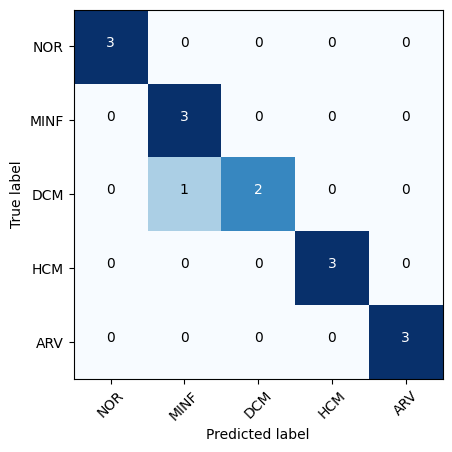

In [ ]:
print ('Results of training MLP:')
scaler = StandardScaler() 
scaler.fit(X_train) 
X_scaled = scaler.transform(X_train)
MLP_clf = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=1, max_iter=1000)
MLP_clf.fit(X_scaled, y_train)

print ('Score on manually segmented Validation Set')
y_pred = MLP_clf.predict(scaler.transform(X_valid))
print (y_pred)
print (MLP_clf.score(scaler.transform(X_valid), y_valid))

# Predict on Manually segmentation results
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_for_cm,
                      title='Confusion matrix: MLP classifier on Validation Set')
# plt.show()
plt.savefig(save_dir+'/confusion_matrix_Manual_MLP')

In [ ]:
forest = RandomForestClassifier(n_estimators=n_estimators,
                                  random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
              axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature: %s \t %d (%f)" % (f + 1, features[indices[f]], indices[f], importances[indices[f]]))

Feature ranking:
1. feature: ES[vol(LV)/vol(RV)] 	 9 (0.112921)
2. feature: EF(LV) 	 6 (0.108070)
3. feature: ED[vol(LV)/vol(RV)] 	 8 (0.096720)
4. feature: ES[vol(LV)] 	 1 (0.092771)
5. feature: ES[vol(MYO)/vol(LV)] 	 11 (0.086722)
6. feature: ED[vol(LV)] 	 0 (0.063605)
7. feature: EF(RV) 	 7 (0.059681)
8. feature: ED[mass(MYO)/vol(LV)] 	 10 (0.047028)
9. feature: ED[max(mean(MWT|SA)|LA)] 	 16 (0.045994)
10. feature: ED[mean(stdev(MWT|SA)|LA)] 	 18 (0.039589)
11. feature: ES[max(mean(MWT|SA)|LA)] 	 12 (0.039484)
12. feature: ED[stdev(stdev(MWT|SA)|LA)] 	 19 (0.037915)
13. feature: ED[mass(MYO)] 	 4 (0.035380)
14. feature: ES[vol(RV)] 	 3 (0.034915)
15. feature: ES[mean(stdev(MWT|SA)|LA)] 	 14 (0.030842)
16. feature: ES[vol(MYO)] 	 5 (0.025759)
17. feature: ED[vol(RV)] 	 2 (0.012136)
18. feature: ES[stdev(stdev(MWT|SA)|LA)] 	 15 (0.011033)
19. feature: ED[stdev(mean(MWT|SA)|LA)] 	 17 (0.010079)
20. feature: ES[stdev(mean(MWT|SA)|LA)] 	 13 (0.009355)


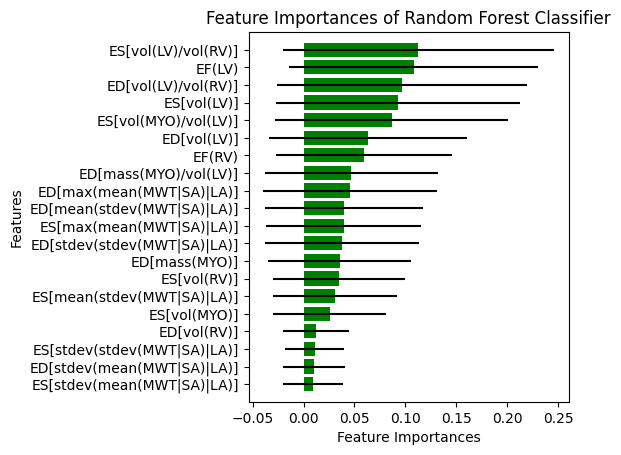

In [ ]:
indices = np.argsort(importances)
plt.rcdefaults()
fig, ax = plt.subplots()
sorted_features =  [features[i] for i in indices]
y_pos = np.arange(len(sorted_features))
ax.barh(y_pos, importances[indices], xerr=std[indices], align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_features)
# ax.invert_yaxis()  # labels read top-to-bottom
# Green bars are the feature importances of the forest and black indicate their inter-trees variability (Stddev)
ax.set_xlabel('Feature Importances')
ax.set_ylabel('Features')

ax.set_title('Feature Importances of Random Forest Classifier')
plt.subplots_adjust(left=0.4)
plt.ylim([-1, X_train.shape[1]])
# plt.show()
plt.savefig(save_dir+'/Important_features')

In [ ]:
print ('Doing cross-validation for Ensemble')
# Cross-validation on full training_set
train_df, train_targets = encode_target(load_dataframe(full_training, shuffle=False), 'GROUP', heart_disease_label_map)
# Select the features:
features = list(train_df.columns[np.r_[START_COL:END_COL]])
# print("* features:", features, sep="\n")
X = train_df[features]
y = train_df['GROUP']
# Scale the feature vectors using standard scaler
scaler = StandardScaler() 
scaler.fit(X) 
X_scaled = scaler.transform(X)

Doing cross-validation for Ensemble


In [ ]:
cross_val_predict(MLPClassifier(hidden_layer_sizes=(100, 100), random_state=1, max_iter=1000), X_scaled, y, cv=5)

array([1, 3, 0, 4, 1, 4, 1, 1, 2, 0, 4, 1, 0, 4, 2, 2, 2, 3, 3, 3, 2, 2,
       2, 4, 3, 1, 4, 2, 0, 0, 4, 1, 4, 2, 4, 1, 3, 2, 4, 2, 0, 0, 2, 2,
       4, 0, 1, 3, 3, 1, 3, 2, 0, 4, 3, 2, 4, 3, 4, 0, 3, 2, 0, 1, 0, 0,
       0, 1, 0, 3, 4, 1, 2, 2, 3, 1, 3, 4, 0, 1, 0, 1, 4, 3, 3, 0, 3, 1,
       0, 1, 3, 3, 2, 4, 4, 1, 4, 1, 2, 0])

In [ ]:
predictions = cross_val_predict(MLPClassifier(hidden_layer_sizes=(100, 100), random_state=1, max_iter=1000), X_scaled, y, cv=5)
y.shape

(100,)

In [ ]:
full_training = "./training_data/parameters_training.csv"
END_COL = 19

In [ ]:
train_df, train_targets = encode_target(load_dataframe(full_training, shuffle=False), 'GROUP', heart_disease_label_map)
# Select the features:
features = list(train_df.columns[np.r_[START_COL:END_COL]])
# print("* features:", features, sep="\n")
X = train_df[features]
y = train_df['GROUP']
# Scale the feature vectors using standard scaler
scaler = StandardScaler() 
scaler.fit(X) 
X_scaled = scaler.transform(X)

# Range of classifiers experimented with
RF_clf = RandomForestClassifier(n_estimators=n_estimators)
XG_clf = XGBClassifier(n_estimators=n_estimators)
MLP_clf = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=1, max_iter=1000)
LR_clf = LogisticRegression()
GNB_clf = GaussianNB()
SVM_clf = svm.SVC(kernel='rbf', probability=True)
KNN_clf = KNeighborsClassifier(n_neighbors=5)

    # Voting Classifier 
E_clf = VotingClassifier(estimators=[('mlp', MLP_clf),  ('gnb', GNB_clf), ('svm', SVM_clf), ('rf', RF_clf)], voting='soft')

for clf, label in zip([LR_clf, RF_clf, GNB_clf, XG_clf, SVM_clf, MLP_clf, KNN_clf, E_clf], ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'XG_boost', 'SVM', 'MLP', 'KNN', 'Ensemble']):
    scores = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy')
    print (scores)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    predictions = cross_val_predict(clf, X_scaled, y, cv=5)
    incorrect_idx = [i for i, val in enumerate(predictions != y) if val]
    print (predictions)
    print (train_df['Name'][incorrect_idx])
    print ('Truth', [class_names[x] for x in y[incorrect_idx]])
    print ('Predicted', [class_names[x] for x in predictions[incorrect_idx]])
    cnf_matrix = confusion_matrix(y, predictions)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names_for_cm,
                          title='Confusion matrix: {} classifier'.format(label))
    # plt.show()
    plt.savefig(save_dir+'/confusion_matrix_Manual_{}'.format(label))
#********************* Evaluate Ensemble classifier model on Validation Set******************************# 
EN_clf = E_clf.fit(X_scaled, y)

ValueError: ignored